In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [127]:
from astropy.cosmology import Planck18
import astropy.units as u
from gwpy.timeseries import TimeSeries
from gwpy.frequencyseries import FrequencySeries
import lal
import lalsimulation as lalsim
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as sig

In [ ]:
fref = 5
fmin = fref
srate = 4096.0

In [183]:
z0 = 2.0
m0 = 1.4
hp, hc = lalsim.SimInspiralChooseTDWaveform(m0*lal.MSUN_SI*(1+z0), m0*lal.MSUN_SI*(1+z0), 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, Planck18.luminosity_distance(z0).to(u.Gpc).value*1e9*lal.PC_SI, 
                                            0.0, 0.0, 0.0, 0.0, 0.0, 1.0/srate, fmin, fref, None, lalsim.TaylorT4)

In [184]:
z1 = 1.0
m1 = 1.4
hp1, hc1 = lalsim.SimInspiralChooseTDWaveform(m1*lal.MSUN_SI*(1+z1), m1*lal.MSUN_SI*(1+z1), 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, Planck18.luminosity_distance(z1).to(u.Gpc).value*1e9*lal.PC_SI, 
                                              0.0, 0.0, 0.0, 0.0, 0.0, 1.0/srate, fmin, fref, None, lalsim.TaylorT4)

In [210]:
z2 = 1.5
m2 = 10.0
hp2, hc2 = lalsim.SimInspiralChooseTDWaveform(m2*lal.MSUN_SI*(1+z2), m2*lal.MSUN_SI*(1+z2), 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, Planck18.luminosity_distance(z2).to(u.Gpc).value*1e9*lal.PC_SI, 
                                              0.0, 0.0, 0.0, 0.0, 0.0, 1.0/srate, fmin, fref, None, lalsim.TaylorT4)

Text(0, 0.5, 'Strain')

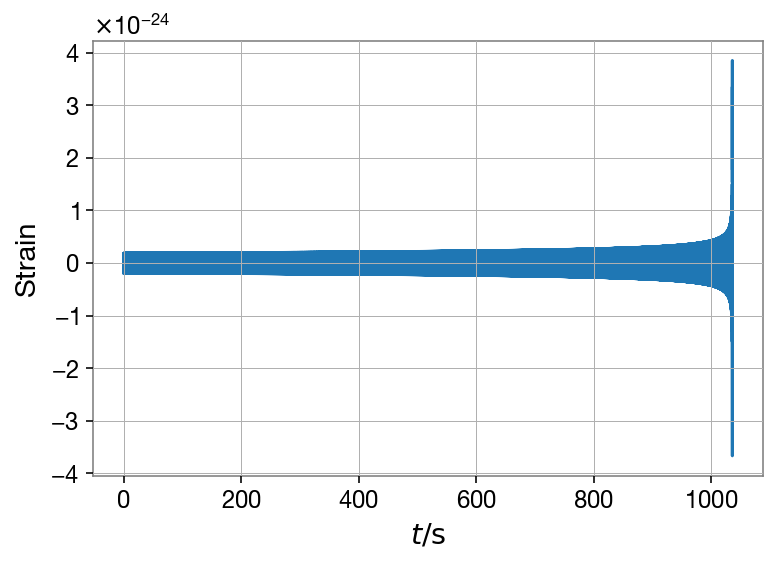

In [185]:
plt.plot(1/srate*np.arange(0, hp.data.data.shape[0]), hp.data.data)
plt.xlabel(r'$t / \mathrm{s}$')
plt.ylabel(r'Strain')

Text(0, 0.5, 'Strain')

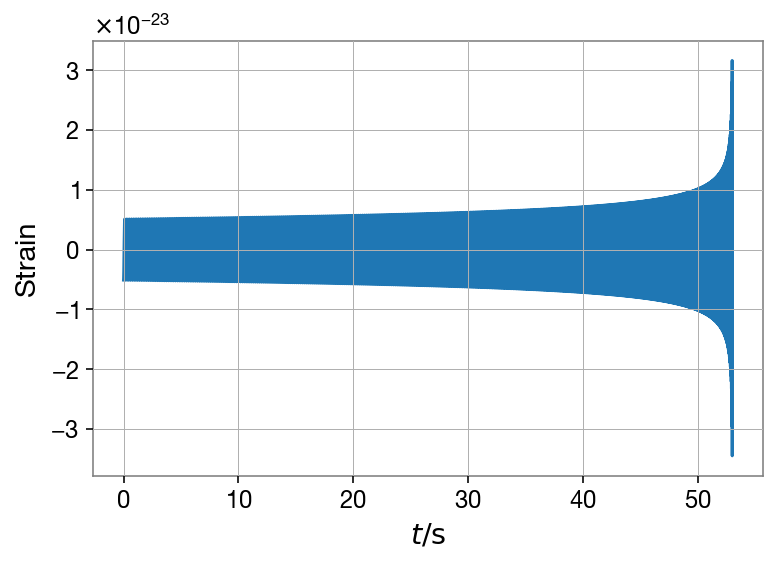

In [212]:
plt.plot(1/srate*np.arange(0, hp2.data.data.shape[0]), hp2.data.data)
plt.xlabel(r'$t / \mathrm{s}$')
plt.ylabel(r'Strain')

In [213]:
T = hp.data.data.shape[0]/srate
f0 = 5
df = 1/T
psd = lal.CreateREAL8FrequencySeries('psd', 0, f0, df, None, hp.data.data.shape[0]//2+1)
lalsim.SimNoisePSDCosmicExplorerP1600143(psd, 0)
psd.data.data[0] = psd.data.data[1]
psd.data.data[-1] = psd.data.data[-2]
psd_centered = 0.5*(psd.data.data[1:] + psd.data.data[:-1])

noise = lal.CreateREAL8TimeSeries('noise', 0, 0, 1.0/srate, lal.StrainUnit, hp.data.data.shape[0])
lalsim.SimNoise(noise, hp.data.data.shape[0], psd, lal.gsl_rng('default', np.random.randint(1<<31)))

0

In [250]:
ts_data = hp.data.data + noise.data.data
N = ts_data.shape[0]

tc1 = 9*60
iend = int(round(tc1*srate))
istart = 0
ts_data[istart:iend] += hp1.data.data[-(iend-istart):]

tc2 = 12*60
iend = int(round(tc2*srate))
istart = iend-hp2.data.data.shape[0]
ts_data[istart:iend] += hp2.data.data

h_timeseries = TimeSeries(ts_data, sample_rate=srate, epoch=0)
asd = FrequencySeries(np.sqrt(psd.data.data), f0=f0, df=df)

q0 = 200
qs = h_timeseries.q_transform(whiten=True, qrange=(q0, q0))

(5, 100)

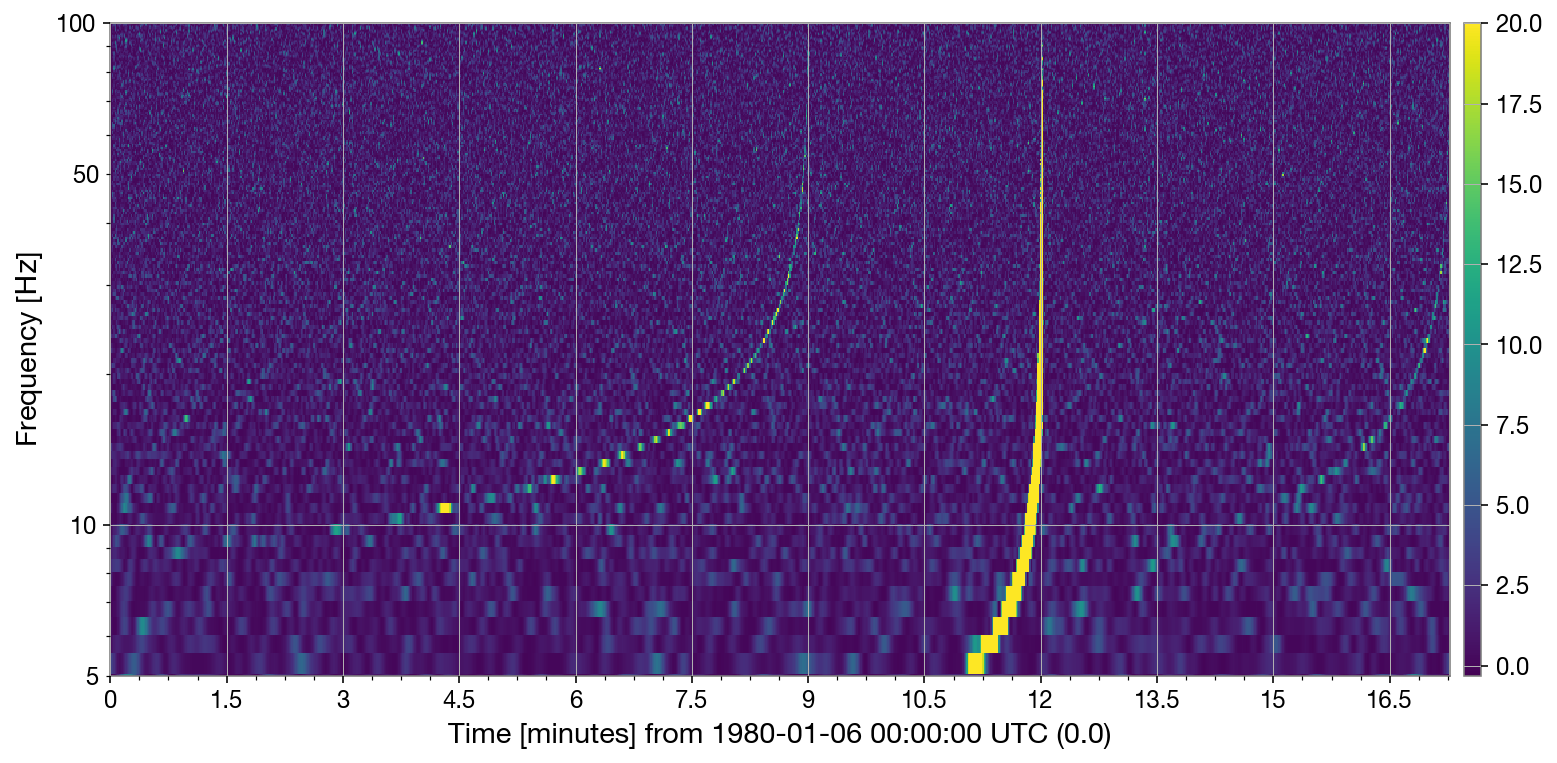

In [251]:
qs.plot(vmax=20)
ax = plt.gca()
ax.colorbar()
ax.set_yscale('log')
ax.set_ylim(5, 100)

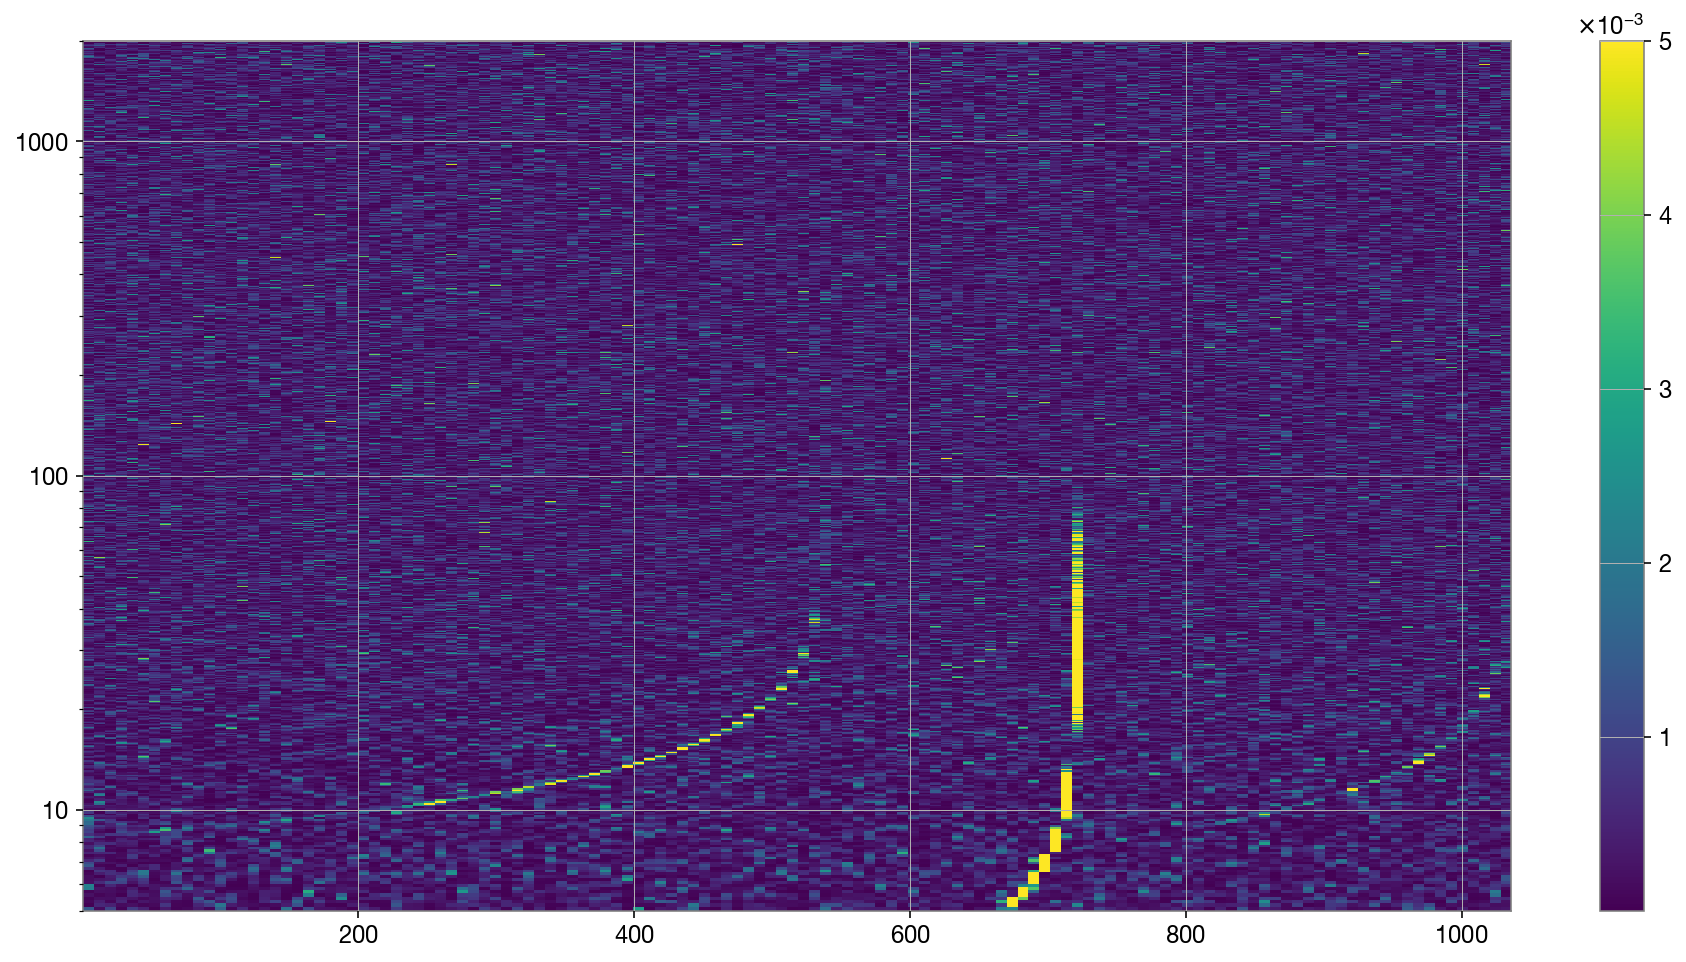

In [267]:
plt.figure(figsize=(16, 8))
plt.specgram(h_timeseries.whiten(), Fs=srate, vmax=.005, NFFT=int(8*srate), scale='linear')
plt.gca().set_yscale('log')
plt.ylim(5, 2e3)
plt.colorbar()